In [2]:
import pandas as pd
import os
import numpy as np
import random 
from scipy.stats import multivariate_normal
import math
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')
train_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/project_data/train_data.csv')
data = train_data.copy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
feature_description = pd.read_excel('/content/drive/My Drive/Colab Notebooks/project_data/data_dictionary.xlsx')
feature_description

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...
...,...,...
148,settlement_amount,The loan amount that the borrower has agreed t...
149,settlement_percentage,The settlement amount as a percentage of the p...
150,settlement_term,The number of months that the borrower will be...
151,NaN,NaN


In [5]:
label = data['loan_status']
data = data.drop(['loan_status'], axis = 1)

for i in range(len(label)):
    if label[i] == 'Charged Off':
        label[i] = 1
    else:
        label[i] = 0

import sklearn.model_selection as model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(data, label, train_size=0.7,test_size=0.3, random_state=101, stratify = label)

In [ ]:
def data_preprocessing(data, miss_threshold, category):
    '''
    Data: dataframe type original data
    miss_threhold: float type, determine whether keep the feature
    category: boolean type, determine whether keep categoical data
    '''
    if category == False: 
        categorical = []
        for name in data.columns:
            for x in data[name][data[name].isna() == False]:
                if type(x) != str:
                    categorical.append(name)
                    break
        data = data[categorical]
                
    
    data = data[[x for x in data.columns if (sum(data[x].isna())/len(data)) <= miss_threshold]]
    unchanged_feature = [x for x in data.columns if len(data[x].unique()) == 1]
    data = data.drop(unchanged_feature, axis = 1)
    
    return data

In [ ]:
miss_threshold = 0.25
category = False
X_train = data_preprocessing(X_train, miss_threshold, category)


In [ ]:
def categorical_check(df, threshold):
    non_cate = []
    for x in df.columns:
        if len(df[x].unique()) >= threshold:
            non_cate.append(x)
            
    return df[non_cate]

In [ ]:
threshold = 100
numerical = categorical_check(X_train, threshold)
numerical3 = numerical.drop(['recoveries', 'out_prncp', 'out_prncp_inv', 'collection_recovery_fee'], axis = 1)
numerical_test3 = X_test[numerical3.columns]

In [ ]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=100, random_state=0)

y_train = np.array(y_train.astype(int))
y_test = np.array(y_test.astype(int))

mice_imp_x = imp.fit_transform(numerical3, y = y_train)
mice_imp_x_test = imp.fit(numerical3, y = y_train).transform(numerical_test3)

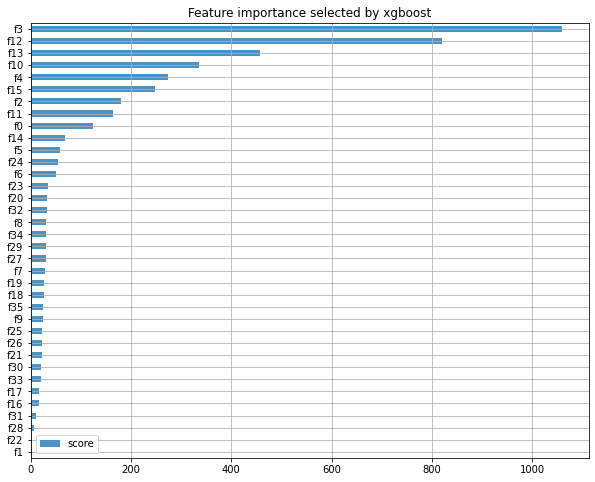

In [ ]:
import xgboost as xgb
dtrain = xgb.DMatrix(mice_imp_x, y_train)
param = {'max_depth':4, 'objective':'binary:logistic', 'nthread': 8, 'eval_metric': 'auc' , 'learning_rate': 0.5, 'n_estimators': 50, 'n_jobs': -1 }

num_round = 300
bst = xgb.train(param, dtrain, num_round)

feature_important = bst.get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

feature_importance = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
feature_importance.plot(kind='barh', grid=True, figsize = (10,8), alpha = 0.8, legend = True, title = 'Feature importance selected by xgboost')

In [ ]:
selected_features = feature_importance.index[feature_importance.score > 50]


selected_features_index = [int(x[1:]) for x in selected_features]
features_names = list(numerical3.columns[selected_features_index])

selected_column_index = []
for x in features_names:
  for i in range(len(X_test.columns)):
    if X_test.columns[i] == x:
      selected_column_index.append(i)


selected_features = [int(x[1:]) for x in selected_features]

feature_x = mice_imp_x[:,selected_features]      


feature_x_test = mice_imp_x_test[:,selected_features]      

In [ ]:
features_names

['mo_sin_old_rev_tl_op',
 'annual_inc',
 'total_rec_late_fee',
 'loan_amnt',
 'total_pymnt_inv',
 'funded_amnt_inv',
 'last_pymnt_amnt',
 'installment',
 'total_pymnt',
 'total_rec_int',
 'total_rec_prncp',
 'int_rate']

In [ ]:
feature_description[feature_description['LoanStatNew'] == 'home_ownership']

,LoanStatNew,Description
26,home_ownership,The home ownership status provided by the borr...


### Manually add some categorical features by the feature description

In [ ]:
new_categoricals = ['delinq_2yrs', 'home_ownership', 'grade', 'purpose']

In [ ]:
new_categoricals = ['delinq_2yrs', 'home_ownership', 'grade', 'purpose']
for x in new_categoricals:
  nan_num = data[x].isna().sum()
  print('The nan number for feature {} is {}'.format(x, nan_num))

The nan number for feature delinq_2yrs is 0
The nan number for feature home_ownership is 0
The nan number for feature grade is 0
The nan number for feature purpose is 0


### Categorical Data Preprocessing

In [ ]:
feature_description

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...
...,...,...
148,settlement_amount,The loan amount that the borrower has agreed t...
149,settlement_percentage,The settlement amount as a percentage of the p...
150,settlement_term,The number of months that the borrower will be...
151,NaN,NaN


In [ ]:
feature_description[feature_description['LoanStatNew'] == 'verification_status']

,LoanStatNew,Description
112,verification_status,"Indicates if income was verified by bank, not ..."


#### We treat the variable ```home_ownership```, ```purpose``` as nominal variable, and ```grade``` ,  ```delinq_2yrs``` and ```verfication_status as ordinal variable (```delinq_2yrs``` might be discrete variable)

In [ ]:
grade_keys= sorted(data['grade'].unique())
grade_values = [i for i in range(len(data['grade'].unique()), 0, -1)]
match_dict = dict(zip(grade_keys, grade_values))
match_dict

{'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}

In [ ]:
for key in match_dict.keys():
  data['grade'][data['grade'] == key] = match_dict[key]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
verify_keys= sorted(data['verification_status'].unique())
verify_values = [0,1,2]
match_dict = dict(zip(verify_keys, verify_values))
for key in match_dict.keys():
  data['verification_status'][data['verification_status'] == key] = match_dict[key]

data['verification_status']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0          2
1          1
2          1
3          1
4          0
          ..
1827120    2
1827121    0
1827122    1
1827123    0
1827124    0
Name: verification_status, Length: 1827125, dtype: object

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
home_ownership = enc.fit_transform(data['home_ownership'].values.reshape(-1,1)).toarray()


In [ ]:
home_ownership = pd.DataFrame(home_ownership, columns = list(enc.categories_[0]))

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')

purpose = enc.fit_transform(data['purpose'].values.reshape(-1,1)).toarray()
purpose = pd.DataFrame(purpose, columns = list(enc.categories_[0]))


In [ ]:
data = data.drop(['purpose', 'home_ownership'], axis = 1)
data = pd.concat([data,home_ownership, purpose ], axis = 1)


In [ ]:
new_col_names = list(purpose.columns) + list(home_ownership.columns) + ['grade'] + ['delinq_2yrs']+ ['verification_status']

### Redo the preprocessing again

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, label, train_size=0.7,test_size=0.3, random_state=101, stratify = label)
miss_threshold = 0.25
category = False
X_train = data_preprocessing(X_train, miss_threshold, category)



numerical3 = X_train.drop(['recoveries', 'out_prncp', 'out_prncp_inv', 'collection_recovery_fee'], axis = 1)
numerical_test3 = X_test[numerical3.columns]

y_train = np.array(y_train.astype(int))
y_test = np.array(y_test.astype(int))

# mice_imp_x = imp.fit_transform(numerical3, y = y_train)
# mice_imp_x_test = imp.fit(numerical3, y = y_train).transform(numerical_test3)


In [ ]:
len(numerical3.columns)

81

In [ ]:
numerical4 = numerical3[[x for x in numerical3.columns if x not in new_col_names]]
numerical_test4 = numerical_test3[list(numerical4.columns)]



In [ ]:
mice_imp_x = imp.fit_transform(numerical4, y = y_train)
mice_imp_x_test = imp.fit(numerical4, y = y_train).transform(numerical_test4)



In [ ]:
mice_imp_x_df = pd.DataFrame(mice_imp_x , columns = list(numerical4.columns))
mice_imp_x_test_df = pd.DataFrame(mice_imp_x_test , columns = list(numerical4.columns))

mice_imp_x_df = mice_imp_x_df[features_names]
mice_imp_x_test_df = mice_imp_x_test_df[features_names]

In [ ]:
mice_imp_x_df = pd.concat([mice_imp_x_df, X_train[new_col_names].reset_index(drop=True)], axis = 1)
mice_imp_x_test_df = pd.concat([mice_imp_x_test_df, X_test[new_col_names].reset_index(drop=True)], axis = 1)


In [ ]:
feature_x = np.array(mice_imp_x_df)
feature_x_test = np.array(mice_imp_x_test_df)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn import metrics

# rf = RandomForestClassifier(max_depth = 24, min_samples_leaf = 4,  n_estimators = 300, class_weight = 'balanced_subsample', n_jobs=-1, criterion = 'gini')
# pred = rf.fit(feature_x, y_train).predict(feature_x_test)
# fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
# metrics.auc(fpr, tpr)

In [ ]:
feature_x.shape

(1278987, 34)

## Model


#### The testing AUC for RUS Adaboost

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.tree import DecisionTreeClassifier

from imblearn.ensemble import RUSBoostClassifier

clf = RUSBoostClassifier(random_state=0, n_estimators=300, learning_rate = 0.6, base_estimator = DecisionTreeClassifier(max_depth=2))
pred = clf.fit(feature_x, y_train).predict(feature_x_test)  

fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)

metrics.auc(fpr, tpr)


0.9003275250100077

* The testing AUC for RUS Boost is 0.900

#### The training AUC for RUS Adaboost 

In [ ]:
clf = RUSBoostClassifier(random_state=0, n_estimators=300, learning_rate = 0.6, base_estimator = DecisionTreeClassifier(max_depth=2))
pred = clf.fit(feature_x, y_train).predict(feature_x)  

fpr, tpr, thresholds = metrics.roc_curve(y_train, pred)

metrics.auc(fpr, tpr)


0.9021743760625676

#### The training AUC for RUS Adaboost is 0.902

### RUS AdaBoost Result Analysis

In [ ]:
scores = clf.fit(feature_x, y_train).predict_proba(feature_x_test)

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, scores[:,1])
auc(fpr, tpr)

0.9697492300695169

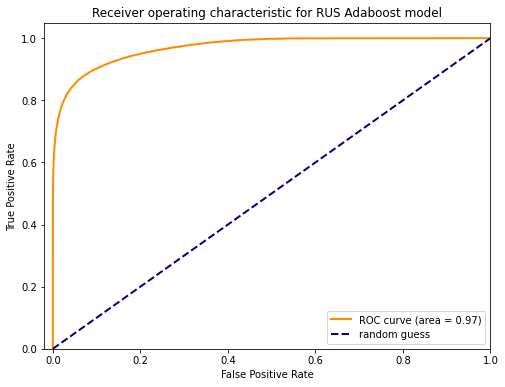

In [ ]:
plt.figure(figsize= (8,6))

lw = 2
plt.plot(fpr, tpr, color='darkorange', 
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label = 'random guess')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for RUS Adaboost model')
plt.legend(loc="lower right")
plt.show()

### Select the best threshold to determine the label

In [ ]:
probs = scores[:, 1]

In [ ]:
def pred_convert(pred, threshold):

  result = np.array([0 for _ in range(len(pred))])
  result[pred.flatten() > threshold] = 1
  return result

In [ ]:
from numpy import arange

threshold = arange(0.49, 0.51, 0.0001)
auc_dict = {}
for x in threshold:
  y_hat = pred_convert(probs, x)
  auc_dict[x] = roc_auc_score(y_test, y_hat)

auc_dict = {k: v for k, v in sorted(auc_dict.items(), key=lambda item: item[1], reverse = True)}


In [ ]:
labels = pred_convert(probs, 0.5)
gmeans = (tpr * (1-fpr))** 0.5
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.500427, G-Mean=0.904


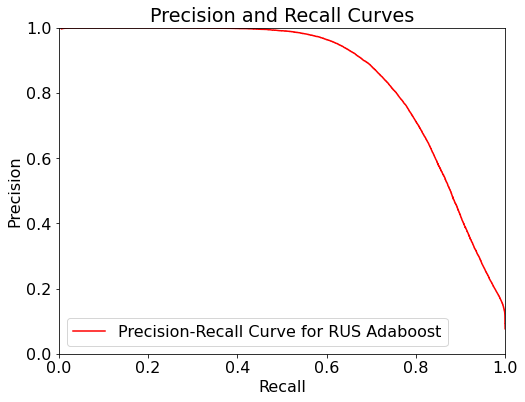

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(
    y_test, probs)



plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
plt.plot(recall, precision, 'r', label='Precision-Recall Curve for RUS Adaboost')
plt.xlabel('Recall') 
plt.ylabel('Precision')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Precision and Recall Curves')
plt.legend(loc="lower left")
plt.show()

Normalized confusion matrix
[[0.89571721 0.10428279]
 [0.09506216 0.90493784]]


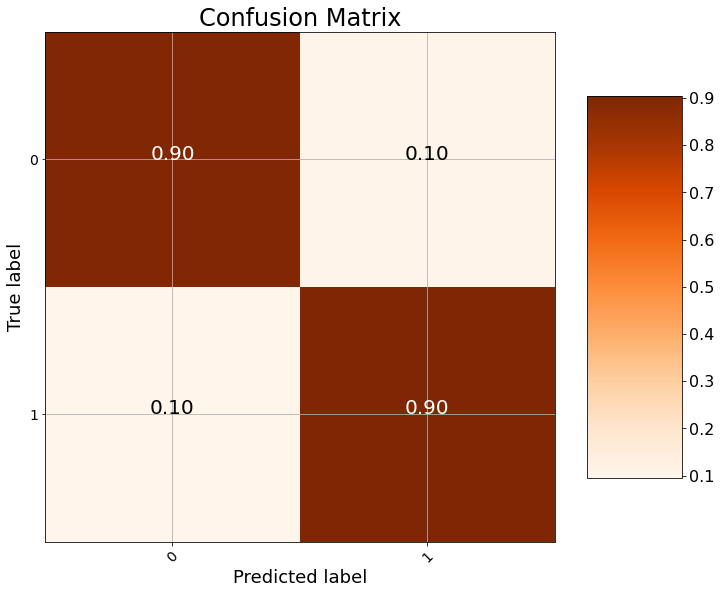

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Confusion matrix
cm = confusion_matrix(y_test, labels)
plot_confusion_matrix(cm, classes = ['0', '1'], normalize = True, 
                      title = 'Confusion Matrix')

In [ ]:
from sklearn.metrics import precision_score, recall_score
print('The macro-averaged precision value is {}.'.format(precision_score(y_test, labels, average="macro")))
print('The macro-averaged recall value is {}.'.format(recall_score(y_test, labels, average="macro"))) 

The macro-averaged precision value is 0.6989686298242299.
The macro-averaged recall value is 0.9003275250100078.


In [ ]:
from sklearn.metrics import precision_score, recall_score
### # A "micro-average": quantifying score on all classes jointly

print('The micro-averaged precision value is {}.'.format(precision_score(y_test, labels, average="micro")))
print('The micro-averaged recall value is {}.'.format(recall_score(y_test, labels, average="micro"))) 

The micro-averaged precision value is 0.896391054807366.
The micro-averaged recall value is 0.896391054807366.


### xgboost with Categorical variable 

In [ ]:
from xgboost import XGBClassifier
from numpy import mean

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

* scale_pos_weight：Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances). 

In [ ]:
from sklearn import metrics

xgb = XGBClassifier(colsample_bytree = 0.7, learning_rate=0.5, max_depth= 20, 
                    scale_pos_weight= 1,  eval_metric = 'auc', n_estimator = 300)

pred = xgb.fit(feature_x, y_train).predict(feature_x_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)

metrics.auc(fpr, tpr)

0.9347271453931557

In [ ]:
weight = round((len(y_train)- y_train.sum()) / y_train.sum(),2)

xgb = XGBClassifier(colsample_bytree = 0.7, learning_rate=0.5, max_depth= 20, 
                    scale_pos_weight= weight,  eval_metric = 'auc', n_estimator = 300)

pred_weighted = xgb.fit(feature_x, y_train).predict(feature_x_test)

fpr2, tpr2, thresholds2 = roc_curve(y_test, pred_weighted)

auc(fpr2, tpr2)

0.9480999983007634

In [ ]:
prod_weighted_xg = xgb.fit(feature_x, y_train).predict_proba(feature_x_test)

fpr_xg2, tpr_xg2, thresholds_xg2 = roc_curve(y_test, prod_weighted_xg[:,1])

auc(fpr_xg2, tpr_xg2)

0.9929861265849215

In [ ]:
threshold = arange(0.0, 1.0, 0.01)
auc_dict = {}
for x in threshold:
  y_hat = pred_convert(prod_weighted_xg[:,1], x)
  auc_dict[x] = roc_auc_score(y_test, y_hat)

auc_dict = {k: v for k, v in sorted(auc_dict.items(), key=lambda item: item[1], reverse = True)}

In [ ]:
label_xg2 = pred_convert(prod_weighted_xg[:,1], 0.02)

Normalized confusion matrix
[[0.97784798 0.02215202]
 [0.04870438 0.95129562]]


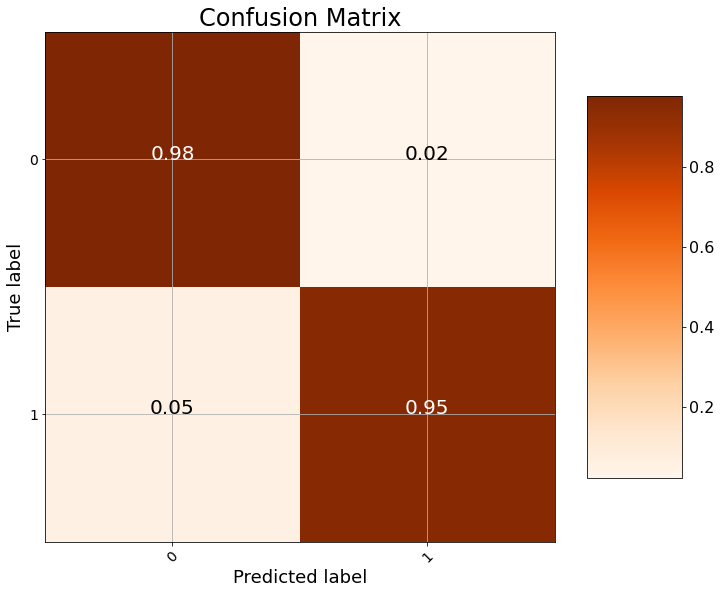

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Confusion matrix
cm = confusion_matrix(y_test, label_xg2)
plot_confusion_matrix(cm, classes = ['0', '1'], normalize = True, 
                      title = 'Confusion Matrix')

In [ ]:
xgb = XGBClassifier(colsample_bytree = 0.7, learning_rate=0.5, max_depth= 20, 
                    scale_pos_weight= 1,  eval_metric = 'auc', n_estimator = 300)

prob = xgb.fit(feature_x, y_train).predict_proba(feature_x_test)


In [ ]:
from sklearn.metrics import precision_score, recall_score
print('The macro-averaged precision value is {}.'.format(precision_score(y_test, pred, average="macro")))
print('The macro-averaged recall value is {}.'.format(recall_score(y_test, pred, average="macro"))) 

The macro-averaged precision value is 0.9885784622037688.
The macro-averaged recall value is 0.9347271453931556.


In [ ]:

print('The micro-averaged precision value is {}.'.format(precision_score(y_test, pred, average="micro")))
print('The micro-averaged recall value is {}.'.format(recall_score(y_test, pred, average="micro"))) 

The micro-averaged precision value is 0.9897051472439422.
The micro-averaged recall value is 0.9897051472439422.


In [ ]:
prob = prob[:, 1]

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, prob)
roc_auc = auc(fpr, tpr)


In [ ]:
gmeans = (tpr * (1-fpr))** 0.5
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.015982, G-Mean=0.963


In [ ]:
threshold = arange(0.0, 1.0, 0.01)
auc_dict = {}
for x in threshold:
  y_hat = pred_convert(prob, x)
  auc_dict[x] = roc_auc_score(y_test, y_hat)

auc_dict = {k: v for k, v in sorted(auc_dict.items(), key=lambda item: item[1], reverse = True)}

In [ ]:
label_xg = pred_convert(prob, 0.02)


* By checking the auc dictionary, the best threshold for xgboost model is 0.02, and the correspoding AUC is 0.963.

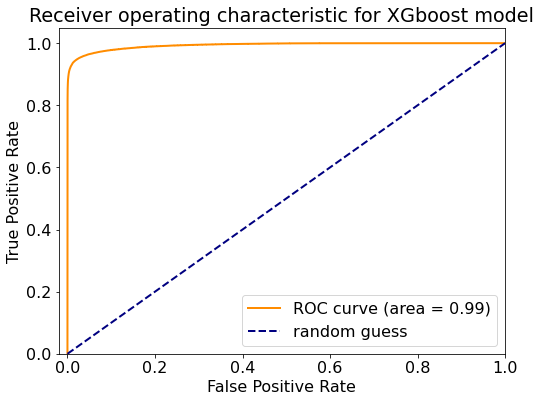

In [ ]:
plt.figure(figsize= (8,6))

lw = 2
plt.plot(fpr, tpr, color='darkorange', 
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label = 'random guess')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for XGboost model')
plt.legend(loc="lower right")
plt.show()

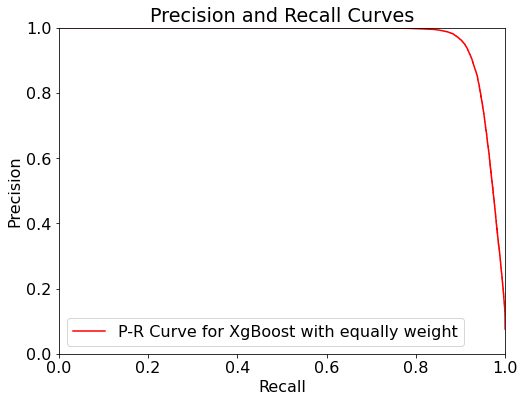

In [ ]:
precision, recall, thresholds = precision_recall_curve(
    y_test, prob)

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
plt.plot(recall, precision, 'r', label='P-R Curve for XgBoost with equally weight')
plt.xlabel('Recall') 
plt.ylabel('Precision')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Precision and Recall Curves')
plt.legend(loc="lower left")
plt.show()

Normalized confusion matrix
[[0.98147536 0.01852464]
 [0.05521993 0.94478007]]


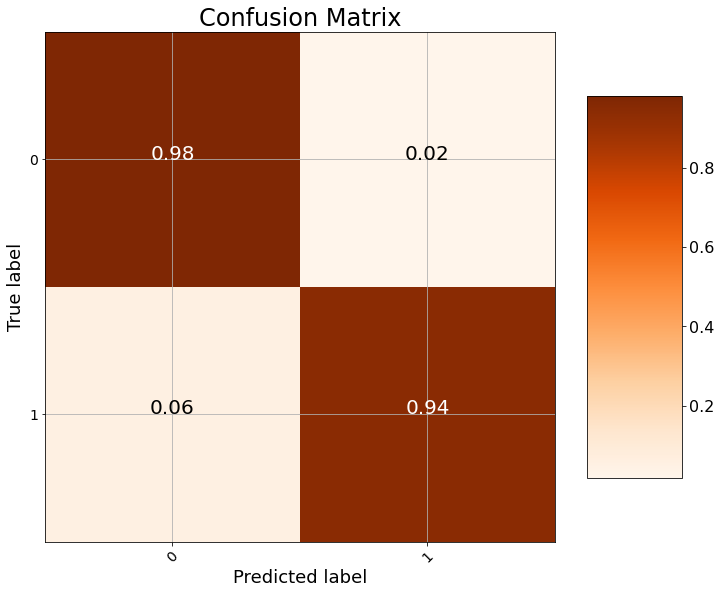

In [ ]:

# Confusion matrix
cm = confusion_matrix(y_test, label_xg)
plot_confusion_matrix(cm, classes = ['0', '1'], normalize = True, 
                      title = 'Confusion Matrix')

### Comparasion different models including XGboost, RUS Adaboost, Random Forest, Logistic Regression, ANN, CNN

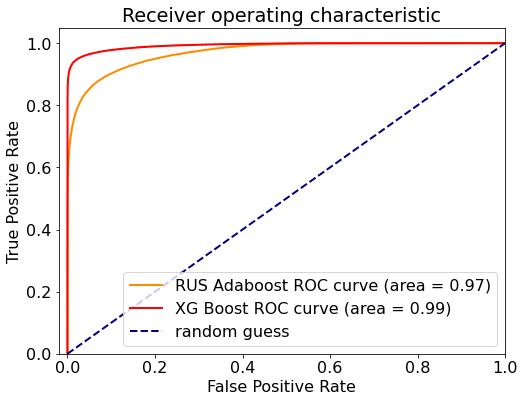

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fpr_ad, tpr_ad, thresholds_ad = roc_curve(y_test, scores[:,1])
auc_ad = auc(fpr_ad, tpr_ad)

fpr_xg, tpr_xg, thresholds_xg = roc_curve(y_test, prob)
roc_auc_xg = auc(fpr_xg, tpr_xg)


plt.figure(figsize= (8,6))

lw = 2
plt.plot(fpr_ad, tpr_ad, color='darkorange', 
         lw=lw, label='RUS Adaboost ROC curve (area = %0.2f)' % auc_ad)

plt.plot(fpr_xg, tpr_xg, color='red', 
         lw=lw, label='XG Boost ROC curve (area = %0.2f)' % roc_auc_xg)


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label = 'random guess')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
rf = RandomForestClassifier(max_depth = 24, min_samples_leaf = 4,  n_estimators = 300, class_weight = 'balanced_subsample', n_jobs=-1, criterion = 'gini')
prob_rf = rf.fit(feature_x, y_train).predict_proba(feature_x_test)


In [ ]:
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, prob_rf[:,1])
metrics.auc(fpr_rf, tpr_rf)

0.9616216842461205

In [ ]:
gmeans = (tpr_rf * (1-fpr_rf))** 0.5
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds_rf[ix], gmeans[ix]))

Best Threshold=0.372206, G-Mean=0.885


In [ ]:
from sklearn import preprocessing

def stadardize(X):
  scaler = preprocessing.StandardScaler().fit(X)
  X = scaler.transform(X)
  return X

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs', penalty = 'l2', n_jobs = -1, max_iter = 200, C = 500, class_weight = 'balanced')

feature_x = np.array(mice_imp_x_df[features_names])
feature_x_test = np.array(mice_imp_x_test_df[features_names])
feature_x = stadardize(feature_x)
feature_x_test = stadardize(feature_x_test)
prob_lr = lr.fit(feature_x, y_train).predict_proba(feature_x_test)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, prob_lr[:,1])
auc(fpr_lr, tpr_lr)

0.938018283630839

In [114]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs', penalty = 'l2', n_jobs = -1, max_iter = 200, C = 1, class_weight = 'balanced')

feature_x = np.array(mice_imp_x_df[features_names])
feature_x_test = np.array(mice_imp_x_test_df[features_names])
feature_x = stadardize(feature_x)
feature_x_test = stadardize(feature_x_test)
prob_lr = lr.fit(feature_x, y_train).predict_proba(feature_x_test)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, prob_lr[:,1])
auc(fpr_lr, tpr_lr)

0.935779643096474

In [115]:
pd.DataFrame(lr.coef_[0],features_names, columns= ['coeffient'])

,coeffient
mo_sin_old_rev_tl_op,0.028356
annual_inc,-0.386361
total_rec_late_fee,0.227967
loan_amnt,19.023402
total_pymnt_inv,46.599502
funded_amnt_inv,-19.527696
last_pymnt_amnt,-4.812569
installment,0.856805
total_pymnt,65.230113
total_rec_int,-28.894912


In [ ]:
lr.coef_[0]

array([ 3.92487989e-02, -5.36204724e-01, -1.77256444e-01,  1.21945892e+02,
        1.98448218e+02, -1.22326516e+02, -4.60267557e+00,  7.98643123e-01,
        3.30865385e+02, -1.38392325e+02, -4.47542582e+02,  2.48206309e-01])

In [ ]:
features_names

['mo_sin_old_rev_tl_op',
 'annual_inc',
 'total_rec_late_fee',
 'loan_amnt',
 'total_pymnt_inv',
 'funded_amnt_inv',
 'last_pymnt_amnt',
 'installment',
 'total_pymnt',
 'total_rec_int',
 'total_rec_prncp',
 'int_rate']

In [ ]:
auc_lr = auc(fpr_lr, tpr_lr)

In [ ]:
roc_auc_rf

0.9616216842461205

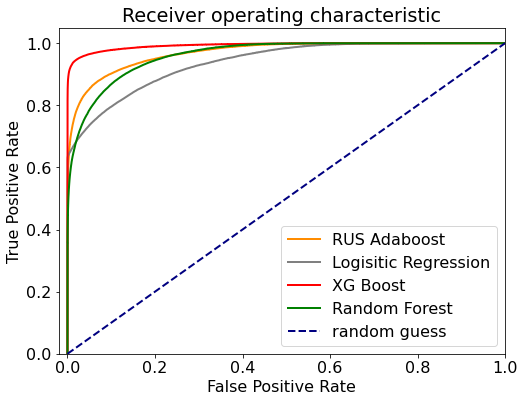

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc



fpr_ad, tpr_ad, thresholds_ad = roc_curve(y_test, scores[:,1])
auc_ad = auc(fpr_ad, tpr_ad)

fpr_xg, tpr_xg, thresholds_xg = roc_curve(y_test, prob)
roc_auc_xg = auc(fpr_xg, tpr_xg)

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, prob_rf[:,1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize= (8,6))

lw = 2
plt.plot(fpr_ad, tpr_ad, color='darkorange', 
         lw=lw, label='RUS Adaboost' )

plt.plot(fpr_lr, tpr_lr, color='grey', 
         lw=lw, label='Logisitic Regression')


plt.plot(fpr_xg, tpr_xg, color='red', 
         lw=lw, label='XG Boost')

plt.plot(fpr_rf, tpr_rf, color='green', 
         lw=lw, label='Random Forest')


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label = 'random guess')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from keras import metrics
from keras.optimizers import Adam

def ANN(n_input):
  model = Sequential()
  model.add(Dense(20, input_dim = n_input, activation= 'relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation= 'relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = [metrics.AUC()])
  return model

In [ ]:
feature_combo_x = np.append(feature_x, np.array(X_train[new_col_names].reset_index(drop=True)), axis= 1)
feature_combo_x_test = np.append(feature_x_test, np.array(X_test[new_col_names].reset_index(drop=True)), axis= 1)

In [ ]:
feature_combo_x = np.asarray(feature_combo_x).astype(np.float32)
feature_combo_x_test = np.asarray(feature_combo_x_test).astype(np.float32)

In [ ]:
from sklearn.metrics import roc_auc_score
from keras.layers import Dense
from keras.models import Sequential

n_input = feature_combo_x.shape[1]
model = ANN(n_input)
history = model.fit(feature_combo_x, y_train, epochs= 20, verbose=2)
# evaluate model
pred_ann = model.predict(feature_combo_x_test)
score = roc_auc_score(y_test, pred_ann)
print('ROC AUC: %.3f' % score)

Epoch 1/20
39969/39969 - 60s - loss: 0.1248 - auc_3: 0.9331
Epoch 2/20
39969/39969 - 60s - loss: 0.1039 - auc_3: 0.9464
Epoch 3/20
39969/39969 - 56s - loss: 0.1003 - auc_3: 0.9489
Epoch 4/20
39969/39969 - 58s - loss: 0.0982 - auc_3: 0.9504
Epoch 5/20
39969/39969 - 58s - loss: 0.0965 - auc_3: 0.9513
Epoch 6/20
39969/39969 - 58s - loss: 0.0953 - auc_3: 0.9521
Epoch 7/20
39969/39969 - 58s - loss: 0.0941 - auc_3: 0.9527
Epoch 8/20
39969/39969 - 62s - loss: 0.0940 - auc_3: 0.9529
Epoch 9/20
39969/39969 - 62s - loss: 0.0933 - auc_3: 0.9535
Epoch 10/20
39969/39969 - 58s - loss: 0.0925 - auc_3: 0.9541
Epoch 11/20
39969/39969 - 62s - loss: 0.0920 - auc_3: 0.9545
Epoch 12/20
39969/39969 - 58s - loss: 0.0918 - auc_3: 0.9548
Epoch 13/20
39969/39969 - 59s - loss: 0.0912 - auc_3: 0.9550
Epoch 14/20
39969/39969 - 59s - loss: 0.0913 - auc_3: 0.9549
Epoch 15/20
39969/39969 - 57s - loss: 0.0909 - auc_3: 0.9552
Epoch 16/20
39969/39969 - 57s - loss: 0.0906 - auc_3: 0.9556
Epoch 17/20
39969/39969 - 57s - l

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CNN, self).__init__()
        kernel_size = 3
        self.input_dim = input_dim
        self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=3, kernel_size=kernel_size)
        self.conv2 = torch.nn.Conv1d(in_channels=3, out_channels=3, kernel_size=kernel_size)
        self.linear1 = nn.Linear((input_dim-2*(kernel_size-1))*3, 10)
        self.linear2 = nn.Linear(10, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input_data):
        conv_out1 = self.conv1(input_data.view(input_data.size()[0], 1, input_data.size()[1]))
        conv_out1 = nn.ReLU()(conv_out1)
        conv_out2 = self.conv2(conv_out1)
        conv_out2 = nn.ReLU()(conv_out2)
        linear1 = self.linear1(conv_out2.view(conv_out2.size()[0], -1))
        linear1 = nn.ReLU()(linear1)
        linear2 = self.linear2(linear1)
        y_pred = self.sigmoid(linear2)
        return y_pred

In [ ]:
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_input = feature_combo_x.shape[1]
cnn_model = CNN(input_dim= n_input, output_dim=1)
cnn_model.to(device)
learning_rate = 0.008
loss_fn = torch.nn.BCELoss(size_average=False)
optimiser = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

In [ ]:
num_epochs = 30
batch_size = 128

train_x = torch.tensor(feature_combo_x.astype(float),dtype = torch.float)
test_x = torch.tensor(feature_combo_x_test.astype(float),dtype = torch.float)
train_y = torch.tensor(y_train,dtype = torch.float)
test_y = torch.tensor(y_test,dtype = torch.float)

for t in range(num_epochs):
    total_loss = 0
    for i in range(len(train_x)//batch_size):
        optimiser.zero_grad()
        batch_data = train_x[i*batch_size:(i+1)*batch_size]
        batch_label = train_y[i*batch_size:(i+1)*batch_size]
        y_pred = cnn_model(batch_data.float())
        # weight = 4 * (batch_label == 1).float() + torch.ones(batch_size, device=device)
        loss = torch.nn.BCELoss()(y_pred, batch_label)        #cnn_writer.add_scalar('CNN loss', loss, t * len(train_data)//batch_size +i)
        total_loss += loss
        loss.backward()
        optimiser.step()
    print("epoch {:d}: {}".format(t, total_loss/(len(train_data)//batch_size)))

epoch 0: 0.098929762840271
epoch 1: 0.08346138894557953
epoch 2: 0.08070623129606247
epoch 3: 0.078996442258358
epoch 4: 0.07806582003831863
epoch 5: 0.07734573632478714
epoch 6: 0.07684843242168427
epoch 7: 0.0763840451836586
epoch 8: 0.07582369446754456
epoch 9: 0.0753263607621193
epoch 10: 0.07492119073867798
epoch 11: 0.07454755157232285
epoch 12: 0.07413537800312042
epoch 13: 0.07379821687936783
epoch 14: 0.07308073341846466
epoch 15: 0.07277193665504456
epoch 16: 0.07251884788274765
epoch 17: 0.07239980250597
epoch 18: 0.0722629725933075
epoch 19: 0.07213317602872849
epoch 20: 0.07196275144815445
epoch 21: 0.07190398126840591
epoch 22: 0.07177552580833435
epoch 23: 0.07169761508703232
epoch 24: 0.07170102745294571
epoch 25: 0.07156853377819061
epoch 26: 0.07155993580818176
epoch 27: 0.07142481952905655
epoch 28: 0.07146844267845154
epoch 29: 0.07136477530002594


In [ ]:
torch.save(cnn_model,(str(cnn_model).split()[0][:-1])+'_2')
cnn_pred = cnn_model(test_x).cpu()
cnn_pred = cnn_pred.data.numpy()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, cnn_pred)
cnn_auc = auc(fpr, tpr)

In [ ]:
gmeans = (tpr_cnn * (1-fpr_cnn))** 0.5
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.000000, G-Mean=0.866


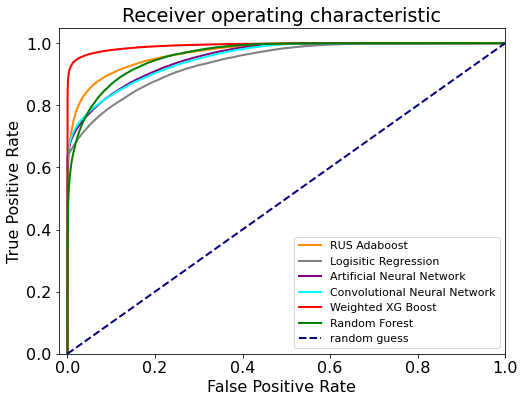

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, prob_lr[:,1])
auc_lr = auc(fpr_lr, tpr_lr)

fpr_ad, tpr_ad, thresholds_ad = roc_curve(y_test, scores[:,1])
auc_ad = auc(fpr_ad, tpr_ad)

fpr_xg, tpr_xg, thresholds_xg = roc_curve(y_test, prob)
roc_auc_xg = auc(fpr_xg, tpr_xg)

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, prob_rf[:,1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_ann, tpr_ann, thresholds_ann = roc_curve(y_test, pred_ann)
roc_auc_ann = auc(fpr_ann, tpr_ann)

fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, cnn_pred)
cnn_auc = auc(fpr, tpr)

plt.figure(figsize= (8,6))

lw = 2
plt.plot(fpr_ad, tpr_ad, color='darkorange', 
         lw=lw, label='RUS Adaboost' )

plt.plot(fpr_lr, tpr_lr, color='grey', 
         lw=lw, label='Logisitic Regression')

plt.plot(fpr_ann, tpr_ann, color='purple', 
         lw=lw, label='Artificial Neural Network')

plt.plot(fpr_cnn, tpr_cnn, color='cyan', 
         lw=lw, label='Convolutional Neural Network')

plt.plot(fpr_xg, tpr_xg, color='red', 
         lw=lw, label='Weighted XG Boost')

plt.plot(fpr_rf, tpr_rf, color='green', 
         lw=lw, label='Random Forest')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label = 'random guess')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right", prop={'size': 11})
plt.show()

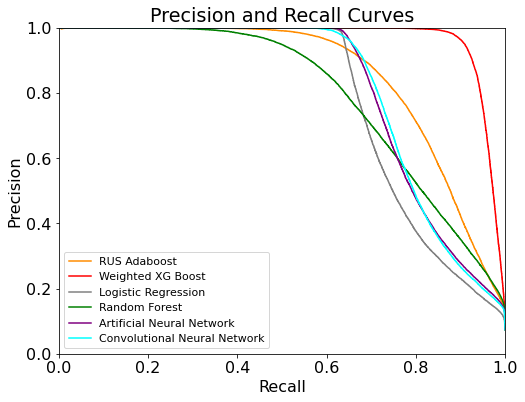

In [ ]:
pre_ad, rec_ad, thresholds_ad = precision_recall_curve(
    y_test, scores[:,1])

pre_xg, rec_xg, thresholds_xg = precision_recall_curve(
    y_test, prob)

pre_rf, rec_rf, thresholds_rf = precision_recall_curve(
    y_test, prob_rf[:,1])

pre_lr, rec_lr, thresholds_lr = precision_recall_curve(
    y_test, prob_lr[:,1])

pre_ann, rec_ann, thresholds_ann = precision_recall_curve(
    y_test, pred_ann)

pre_cnn, rec_cnn, thresholds_cnn = precision_recall_curve(
    y_test, cnn_pred)



plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16

plt.plot(rec_ad, pre_ad, 'darkorange', label='RUS Adaboost')
plt.plot(rec_xg, pre_xg, 'red', label='Weighted XG Boost')
plt.plot(rec_lr, pre_lr, 'grey', label='Logistic Regression')
plt.plot(rec_rf, pre_rf, 'green', label='Random Forest')
plt.plot(rec_ann, pre_ann, 'purple', label='Artificial Neural Network')
plt.plot(rec_cnn, pre_cnn, 'cyan', label='Convolutional Neural Network')




plt.xlabel('Recall') 
plt.ylabel('Precision')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Precision and Recall Curves')
plt.legend(loc="lower left", prop={'size': 11})
plt.show()

In [ ]:
lr = LogisticRegression(solver='lbfgs', penalty = 'l2', n_jobs = -1, max_iter = 200, C = 500, class_weight = 'balanced')

feature_x = np.array(mice_imp_x_df[features_names])
feature_x_test = np.array(mice_imp_x_test_df[features_names])
feature_x = stadardize(feature_x)
feature_x_test = stadardize(feature_x_test)
# prob_lr = lr.fit(feature_x, y_train).predict_proba(feature_x_test)
# fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_test, prob_lr[:,1])
# metrics.auc(fpr_lr, tpr_lr)

In [ ]:

# grid search k value for SMOTE oversampling for imbalanced classification
from numpy import mean

from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


over = SMOTE(sampling_strategy=0.1, k_neighbors = 3)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', lr)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_val_score(pipeline, feature_x, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.939


In [ ]:

prob_lr2 = pipeline.fit(feature_x, y_train).predict_proba(feature_x_test)
fpr_lr2, tpr_lr2, thresholds_lr2 = roc_curve(y_test, prob_lr2[:,1])
auc(fpr_lr2, tpr_lr2)

0.9378416791243942

In [112]:
auc(fpr_lr, tpr_lr)

0.938018283630839

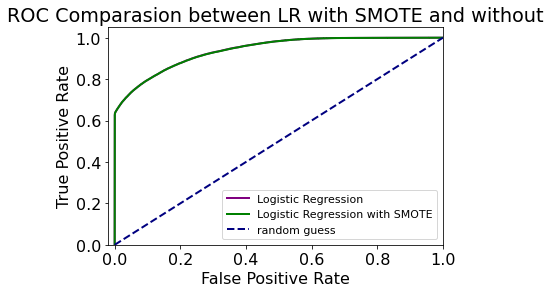

In [113]:
lw = 2


plt.plot(fpr_lr, tpr_lr, color='purple', 
         lw=lw, label='Logistic Regression')

plt.plot(fpr_lr2, tpr_lr2, color='green', 
         lw=lw, label='Logistic Regression with SMOTE')


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label = 'random guess')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Comparasion between LR with SMOTE and without')
plt.legend(loc="lower right", prop={'size': 11})
plt.show()

## Predict the real test data


* Try three models RUS Adaboost, Xgboost, Random Forest

* Predict the scores 

* Convert the scores to labels and compare the Jacobian difference


In [6]:
real_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/project_data/updated_test_data_20200728.csv')


In [7]:
real_test2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/project_data/updated_test_data_20200728.csv')


In [8]:
grade_keys= sorted(real_test['grade'].unique())
grade_values = [i for i in range(len(real_test['grade'].unique()), 0, -1)]
match_dict = dict(zip(grade_keys, grade_values))
match_dict

{'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}

In [9]:
for key in match_dict.keys():
  real_test['grade'][real_test['grade'] == key] = match_dict[key]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
verify_keys= sorted(real_test['verification_status'].unique())
verify_values = [0,1,2]
match_dict = dict(zip(verify_keys, verify_values))
for key in match_dict.keys():
  real_test['verification_status'][real_test['verification_status'] == key] = match_dict[key]

real_test['verification_status']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0         1
1         0
2         0
3         2
4         2
         ..
211622    1
211623    2
211624    0
211625    2
211626    2
Name: verification_status, Length: 211627, dtype: object

In [12]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
home_ownership = enc.fit_transform(real_test['home_ownership'].values.reshape(-1,1)).toarray()
home_ownership = pd.DataFrame(home_ownership, columns = list(enc.categories_[0]))

In [13]:
purpose = enc.fit_transform(real_test['purpose'].values.reshape(-1,1)).toarray()
purpose = pd.DataFrame(purpose, columns = list(enc.categories_[0]))


In [ ]:
data = data.drop(['purpose', 'home_ownership'], axis = 1)
data = pd.concat([data,home_ownership, purpose ], axis = 1)
